This notebook is adapted from the SISL playground

In [21]:
# Just to define file paths, not related to sisl
from pathlib import Path

# Sisl imports
import sisl
import sisl.viz

# To quickly plot the hamiltonian matrix
import plotly.express as px

In [22]:
#Get the fdf file for the calculation
path_uc = Path("/mnt/c/Users/angel/Documents/GitHub/graph2mat4abn/dataset/SHARE_OUTPUTS_2_ATOMS/0a4c-6759-46e6-bf5e-6439eefcaad2")   #SIESTA calculation folder
fdf_uc = sisl.get_sile(path_uc / "aiida.fdf")        #the fdf file inside it (the name xxxx.fdf could change)

In [23]:
#Optional: as a test, plot the unit cell
fdf_uc.plot.geometry(axes="xz")

In [24]:
#Read the Hamiltonian data
H_uc = fdf_uc.read_hamiltonian()

In [25]:
#Optional: have a look at what is inside:
H_uc

<sisl.physics.Hamiltonian na=2, no=26, nsc=[5 5 5], dim=2, nnz=12670, spin=unpolarized>

In [26]:
#Extract the Hamiltonian / "supercell matrix" and the corresponding overlap matrix
H_matrix = H_uc.tocsr()  #it is stored in sparse format
S_matrix = H_uc.Sk(format='sc')  #dirty cheat: we call for Sk in supercell format at Gamma

In [27]:
import numpy as np

def writesparse_CSR2COO(filename,Mat_CSR):
    """
    Takes CSR matrix Mat and save it as COO data to disk at address filename.
    Inputs:
    filename: string, address where the matrix will be saved
    Mat_CSR: CSR matrix, matrix to be saved in COO format: nnzx4 array with columns (row col Re(Mij) Im(Mij)), with the shape information written in the header in the format: nrows ncols nnz
    """
    Mat_COO=Mat_CSR.tocoo()
    
    #form the array of data to be saved
    ToSave=np.zeros((Mat_COO.nnz,4))
    ToSave[:,0]=Mat_COO.row
    ToSave[:,1]=Mat_COO.col
    ToSave[:,2]=np.real(Mat_COO.data)
    ToSave[:,3]=np.imag(Mat_COO.data)
    
    #np.savetxt(filename, ToSave, header='row | col | Re | Im', fmt='%i %i %.18f %.18f')  #save to disk
    np.savetxt(filename, ToSave, header=f'{Mat_COO.shape[0]} {Mat_COO.shape[1]} {Mat_COO.nnz}', fmt='%i %i %.18f %.18f', comments='')  #save to disk

#Write the matrices to disk
#writesparse_CSR2COO('ham_coo', H_matrix)
#writesparse_CSR2COO('over_coo', S_matrix)

In [28]:
#Optional: plot the Hamiltonian
H_matrix_toplot=H_matrix.copy().toarray()  #convert to an array
H_matrix_toplot[H_matrix_toplot == 0] = None  #put the zero elements to None so that they are not plotted
px.imshow(H_matrix_toplot)

In [29]:
#Optional: plot the Overlap Matrix
S_matrix_toplot=S_matrix.copy().toarray()  #convert to an array
S_matrix_toplot[S_matrix_toplot == 0] = None  #put the zero elements to None so that they are not plotted
px.imshow(S_matrix_toplot)

In [30]:
#We now want to reconstruct the Transfer Integral and Overlap Matrices at an arbitrary k
geom = H_uc.geometry

A_lat=geom.cell  #array of lattice vectors

H_coo= H_matrix.tocoo()   #coo representation of the "supercell" Hamiltonian
S_coo= S_matrix.tocoo()   #coo representation of the "supercell" Hamiltonian

In [31]:
#Some auxiliary quantities

orb_i=-np.ones(H_coo.nnz, dtype=int) #we fill everything with minus ones to be able to detect iif something went wrong
orb_j=-np.ones(H_coo.nnz, dtype=int) #same
isc=-np.ones((H_coo.nnz,3), dtype=int) #same

orb_i=H_coo.row
for k in range(0, H_coo.nnz):
    #orb_i[k]=geom.osc2uc(H_coo.row[k])  #it would do the same as above, since teh rows stay in the u.c.
    orb_j[k]=geom.osc2uc(H_coo.col[k])   #unit cell orbital indices corresponding to the "supercell" indices
    isc[k]=geom.o2isc(H_coo.col[k])      #which unit cell / shift that orbital belongs to wrt. the (0,0,0) unit cell
print('Done.')

Done.


In [32]:
#We try again to reconstruct the matrices

def ReconstructHS(k_cart, H_coo, S_coo, orb_i, orb_j, isc, A_lat):

    no=H_coo.shape[0]    #number of rows of H_matrix, i.e. number of orbitals
    H_g=np.zeros((no, no), dtype=complex) #no x no matrix of zeros for our H(k) which we wil now fill (it may be wasteful to use a dense matrix for that, but we do it here for simplicity)
    S_g=np.zeros((no, no), dtype=complex)

    kpt=k_cart  #the k-point at which we will attempt reconstruction

    for k in range(0, H_coo.nnz):
        Ruc=A_lat[0]*isc[k,0]+A_lat[1]*isc[k,1]+A_lat[2]*isc[k,2]  #unit cell to unit cell repetition distance (i.e. cell phase convention)
        #Ruc=geom.oRij(H_coo.row[k], H_coo.col[k])  #using the Ruc wil lead to the atomic phase convention
        Phase=np.exp(1j*kpt.dot(Ruc))
        H_g[orb_i[k],orb_j[k]]+=H_coo.data[k]*Phase   #add contribution to correct entry of H(k)
        S_g[orb_i[k],orb_j[k]]+=S_coo.data[k]*Phase   #H ans S have the same sparsity structure

    return H_g, S_g


kpt=np.array([6,0,8])  #the k-point at which we will attempt reconstruction, in cartesian (?) coordinates

H_g, S_g = ReconstructHS(kpt, H_coo, S_coo, orb_i, orb_j, isc, A_lat)

#Our reconstructed matrices should now be done

#k_red=kpt*A_lat[2,2]/(2*np.pi)
#k_red=np.linalg.inv(A_lat.T)@kpt
k_red=(A_lat.T)@kpt/(2*np.pi)   #weird conversion here, I would expect the above one for cart->red...

#We compute the SISL ones, for comparison
Hks=H_uc.Hk(k_red, gauge='cell')  #Here be careful to choose the same phase convention as the one used for the definition of Ruc
Sks=H_uc.Sk(k_red, gauge='cell')  #Note the use of the "converted" k, k_red

#check they are the same
MatsCloseH=np.allclose(H_g, Hks.toarray())
print(f'np.allcose between the two transfer integral matrices returns: {MatsCloseH}')

MatsCloseS=np.allclose(S_g, Sks.toarray())
print(f'np.allcose between the two overlap matrices returns: {MatsCloseS}')

#plot the difference
px.imshow(np.abs(H_g-Hks.toarray()))

np.allcose between the two transfer integral matrices returns: True
np.allcose between the two overlap matrices returns: True


In [33]:
px.imshow(np.abs(S_g-Sks.toarray()))

In [34]:
#Check if eigenvalues are the same (they should be even if we are using different conventions)
import scipy.linalg

vals_rec = scipy.linalg.eigh(H_g, S_g, eigvals_only=True)
vals_si=scipy.linalg.eigh(Hks.toarray(), Sks.toarray(), eigvals_only=True)
px.scatter(x=vals_rec, y=vals_si)

In [35]:
import matplotlib.pyplot as plt

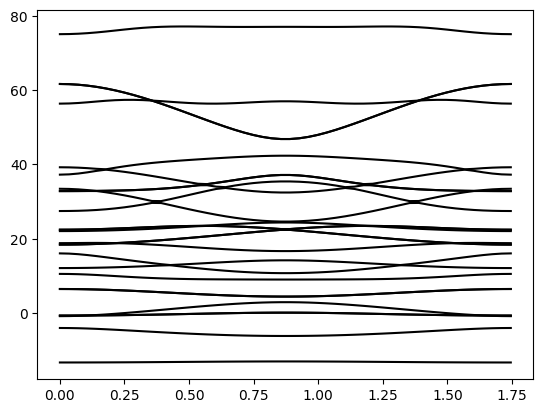

In [36]:
#We try plotting the lowest "band" to convince ourselves...

#Using the SISL functions with reduced k points

#kzs=2*np.pi*np.linspace(0,1, num=50)/3.59999
kzs=np.linspace(0,1, num=50)
kdir=geom.rcell[:,2]
ktest=np.array([kz*kdir for kz in kzs])
Band_end=np.array([scipy.linalg.eigh(H_uc.Hk((A_lat.T)@kp/(2*np.pi), gauge='cell').toarray(), H_uc.Sk((A_lat.T)@kp/(2*np.pi), gauge='cell').toarray())[0] for kp in ktest])  #we convert internally

plt.plot(kzs*np.linalg.norm(kdir), Band_end, color='black')
plt.show()

In [37]:
#Using our manually reconstructed Integral Transfer Matrices with cartesian k points

#construct a k-path (here a simplistic one, just for testing)
kzs=np.linspace(0,1, num=50)
kdir=geom.rcell[:,2]
ktest=np.array([kz*kdir for kz in kzs])  #the k-path (here, for testing, we just go along b_2 from Gamma to the next Gamma point over)
k_abscissa=kzs*np.linalg.norm(kdir)  #the abscissa for the band plot

#Compute the H(k) and S(k) and diagonalize
Mats=[ReconstructHS(kp, H_coo, S_coo, orb_i, orb_j, isc, A_lat) for kp in ktest]  #list of (Hk, Sk) for the k points
Band_enenergies=np.array([scipy.linalg.eigh(Mats[k_num][0], Mats[k_num][1], eigvals_only=True) for k_num in range(0,ktest.shape[0])])  #get eigenvalues at each k-point

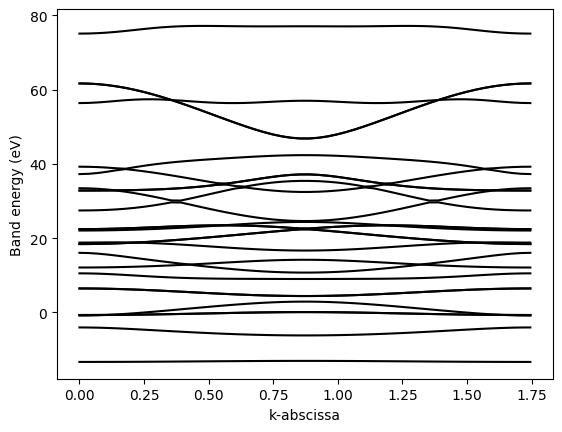

In [38]:
#Plot the results
plt.plot(kzs*np.linalg.norm(kdir), Band_enenergies, color='black')
plt.xlabel('k-abscissa')
plt.ylabel('Band energy (eV)')
plt.show()